In [47]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
import scipy
import scipy as sp
from scipy.optimize import fsolve
import scipy

In [62]:
alpha = 0.25; Bo=0.1; Ca=0.1; Re=0; Ma=0; epsilon=0.1

In [63]:
def w_0(x):
    r = ((1-alpha)*x+1+alpha)/2
    return 1/4*(2*np.log(r/alpha)-(r**2-alpha**2))
def w_0_prime(x):
    r = ((1-alpha)*x+1+alpha)/2
    return 1/2*(1/r-r)
w_0 = np.vectorize(w_0)
w_0_prime = np.vectorize(w_0_prime)

In [64]:
N =  200
x = np.flip(cheb.chebgauss(N+1)[0])
x_interior = x[1:-1]
matrix = np.zeros((N+1, N+1))
#build the polys at the points
cheb_poly = np.zeros((N+1, N+1))
cheb_der = np.zeros_like(cheb_poly)
cheb_der_der = np.zeros_like(cheb_poly)
# row is the order, column is the evaluation point
cheb_poly[0,:] = 1
cheb_poly[1,:] = x
cheb_der[1,:] = 1
for k in range(2,N+1):
    cheb_poly[k,:] = 2*x*cheb_poly[k-1,:] - cheb_poly[k-2,:]
    cheb_der[k,:] = 2*cheb_poly[k-1] + 2*x*cheb_der[k-1, :] - cheb_der[k-2, :]
    cheb_der_der[k,:] = 4*cheb_der[k-1]+2*x*cheb_der_der[k-1, :]-cheb_der_der[k-2, :]

In [60]:
kappa_vect = np.linspace(0, 1, 20)
Lambda_vect = np.zeros_like(kappa_vect)
r_interior = (1-alpha)*x_interior + (1+alpha) #(half)

for index, kappa in enumerate(kappa_vect):
    #continuity first
    matrix_a_cont = np.zeros((N-1, N+1), dtype=complex)
    matrix_b_cont = np.zeros((N-1, N+1), dtype=complex)
    matrix_c_cont = np.zeros((N-1, N+1), dtype=complex)
    matrix_S_cont = np.zeros((N-1, 1), dtype = complex)
    
    matrix_a_cont += np.transpose(2/(1-alpha)*cheb_der[:,1:-1] + 2/(r_interior)*cheb_poly[:,1:-1])
    matrix_b_cont += np.transpose(1j*kappa*cheb_poly[:, 1:-1])

    matrix_cont = np.concatenate([matrix_a_cont, matrix_b_cont, matrix_c_cont, matrix_S_cont], axis=1)
    
    matrix_cont_forcing = np.zeros_like(matrix_cont)
    # Ns in r direction (or x direction now)
    matrix_a_NSr = np.zeros((N-1, N+1), dtype=complex)
    matrix_b_NSr = np.zeros((N-1, N+1), dtype=complex)
    matrix_c_NSr = np.zeros((N-1, N+1), dtype=complex)
    matrix_S_NSr = np.zeros((N-1, 1), dtype = complex)
    matrix_a_NSr_forcing = np.zeros((N-1, N+1), dtype=complex)
    
    matrix_a_NSr += np.transpose(Re*w_0(x_interior)*1j*kappa*cheb_poly[:, 1:-1] + kappa**2*cheb_poly[:, 1:-1])
    matrix_a_NSr += np.transpose(-4/(1-alpha)**2*cheb_der_der[:,1:-1] + 4/(r_interior**2)*cheb_poly[:,1:-1])
    matrix_a_NSr += np.transpose(-2*cheb_der[:,1:-1]/r_interior)
    
    matrix_c_NSr += np.transpose(2/(1-alpha)*cheb_der[:,1:-1])
    
    matrix_a_NSr_forcing += np.transpose(-Re*cheb_poly[:,1:-1])
    
    matrix_NSr = np.concatenate([matrix_a_NSr, matrix_b_NSr, matrix_c_NSr, matrix_S_NSr], axis=1)

    matrix_NSr_forcing = np.concatenate([matrix_a_NSr_forcing, np.zeros((N-1, N+1), dtype=complex), 
                                         np.zeros((N-1, N+1), dtype=complex), 
                                         np.zeros((N-1, 1), dtype = complex)], axis=1)
    
    #NS in z
    matrix_a_NSz = np.zeros((N-1, N+1), dtype=complex)
    matrix_b_NSz = np.zeros((N-1, N+1), dtype=complex)
    matrix_c_NSz = np.zeros((N-1, N+1), dtype=complex)
    matrix_S_NSz = np.zeros((N-1, 1), dtype = complex)
    matrix_b_NSz_forcing = np.zeros((N-1, N+1), dtype=complex)
    
    matrix_a_NSz += np.transpose(Re*w_0_prime(x_interior)*cheb_poly[:,1:-1])
    matrix_b_NSz += np.transpose(Re*1j*kappa*w_0(x_interior)*cheb_poly[:,1:-1]+kappa**2*cheb_poly[:,1:-1])
    matrix_b_NSz += np.transpose(-4/(1-alpha)**2*cheb_der_der[:,1:-1]-2/r_interior*cheb_der[:,1:-1])
    matrix_c_NSz += np.transpose(1j*kappa*cheb_poly[:,1:-1])
    
    matrix_b_NSz_forcing += np.transpose(-Re*cheb_poly[:,1:-1])
    matrix_NSz = np.concatenate([matrix_a_NSz, matrix_b_NSz, matrix_c_NSz, matrix_S_NSz], axis=1)
    
    matrix_NSz_forcing = np.concatenate([np.zeros((N-1, N+1), dtype=complex), matrix_b_NSz_forcing,
                                         np.zeros((N-1, N+1), dtype=complex), 
                                         np.zeros((N-1, 1), dtype = complex)], axis=1)
    # u(r = alpha) = u(x=-1)=0
    no_slip = np.transpose(cheb_poly[:,0]).reshape(1,-1)
    matrix_noslip_u = np.concatenate([no_slip,np.zeros_like(no_slip),np.zeros_like(no_slip)], axis=1)
    # no slip w
    matrix_noslip_w = np.concatenate([np.zeros_like(no_slip),no_slip,
                                      np.zeros_like(no_slip)], axis=1)
    # du/dr=0 at r=alpha (du/dx=0 at x=-1)
    derivative = np.transpose(cheb_der[:,0]).reshape(1, -1)
    matrix_no_derivative_u = np.concatenate([derivative, np.zeros_like(derivative),
                                      np.zeros_like(derivative)], axis=1)
    # join them and add column for S
    BC_at_wire_almost = np.concatenate([matrix_noslip_u, matrix_noslip_w, matrix_no_derivative_u], axis=0)
    matrix_BC_at_wire = np.concatenate([BC_at_wire_almost, np.zeros((3,1))], axis=1)
    matrix_BC_at_wire_forcing = np.zeros_like(matrix_BC_at_wire)

    
    #kinematic 
    length_row = len(np.transpose(cheb_poly[:,-1]).reshape(1,-1))
    condition_for_u = np.transpose(cheb_poly[:,-1]).reshape(1,-1)
    matrix_kinematic=np.concatenate([condition_for_u, 
                                   np.zeros_like(condition_for_u), 
                                   np.zeros_like(condition_for_u), 
                                   np.array([[-w_0(x[-1])*1j*kappa]])], axis=1)
    matrix_kinematic_forcing = np.concatenate([np.zeros_like(condition_for_u), np.zeros_like(condition_for_u),
                                               np.zeros_like(condition_for_u), np.array([[1]])], axis = 1)
    
    # tangential 
    matrix_tangential = np.concatenate([1j*kappa*cheb_poly[:,-1].reshape(1,-1),
                                        2/(1-alpha)*cheb_der[:,-1].reshape(1,-1),
                                        np.zeros_like(condition_for_u),
                                       np.array([[-1]])], axis =1)
    
    #normal
    matrix_normal = np.concatenate([(-4*Ca/(1-alpha))*cheb_der[:,-1].reshape(1,-1), 
                                   np.zeros_like(condition_for_u), 
                                   Bo*cheb_poly[:,-1].reshape(1,-1), np.array([[(1-2*Ma)-kappa**2]])], axis=1)
    matrix_BC_free_surface = np.concatenate([matrix_kinematic, matrix_tangential, matrix_normal], axis=0)
    matrix_BC_free_surface_forcing = np.concatenate([matrix_kinematic_forcing,
                                                     np.zeros_like(matrix_kinematic_forcing),
                                                    np.zeros_like(matrix_kinematic_forcing)], 
                                                    axis=0)
    #continuity at r=1
    
    cont_at_free_surface = np.concatenate([(2/(1-alpha)*cheb_der[:,0] + 2/(x[-1])*cheb_poly[:,0]).reshape(1,-1), 
                                          (1j*kappa*cheb_poly[:, 0]).reshape(1,-1), 
                                          np.zeros_like((1j*kappa*cheb_poly[:, 0]).reshape(1,-1)), 
                                          np.array([[0]])], axis =1)


    
    matrix = np.concatenate([matrix_cont, matrix_NSr, matrix_NSz, 
                             matrix_BC_at_wire, matrix_BC_free_surface, cont_at_free_surface],
                           axis=0)
    matrix_forcing = np.concatenate([matrix_cont_forcing, matrix_NSr_forcing, matrix_NSz_forcing, 
                                    matrix_BC_at_wire_forcing, matrix_BC_free_surface_forcing,
                                     np.zeros_like( cont_at_free_surface)], axis=0)
    #print(np.shape(matrix))
    #print(np.shape(matrix_forcing))
    evals = scipy.linalg.eigvals(matrix,matrix_forcing).real
    #print(evals)
    Lambda_vect[index] = np.max(evals[~np.isinf(evals)])
    print((index+1)/len(kappa_vect)*100)

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.00000000000001
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


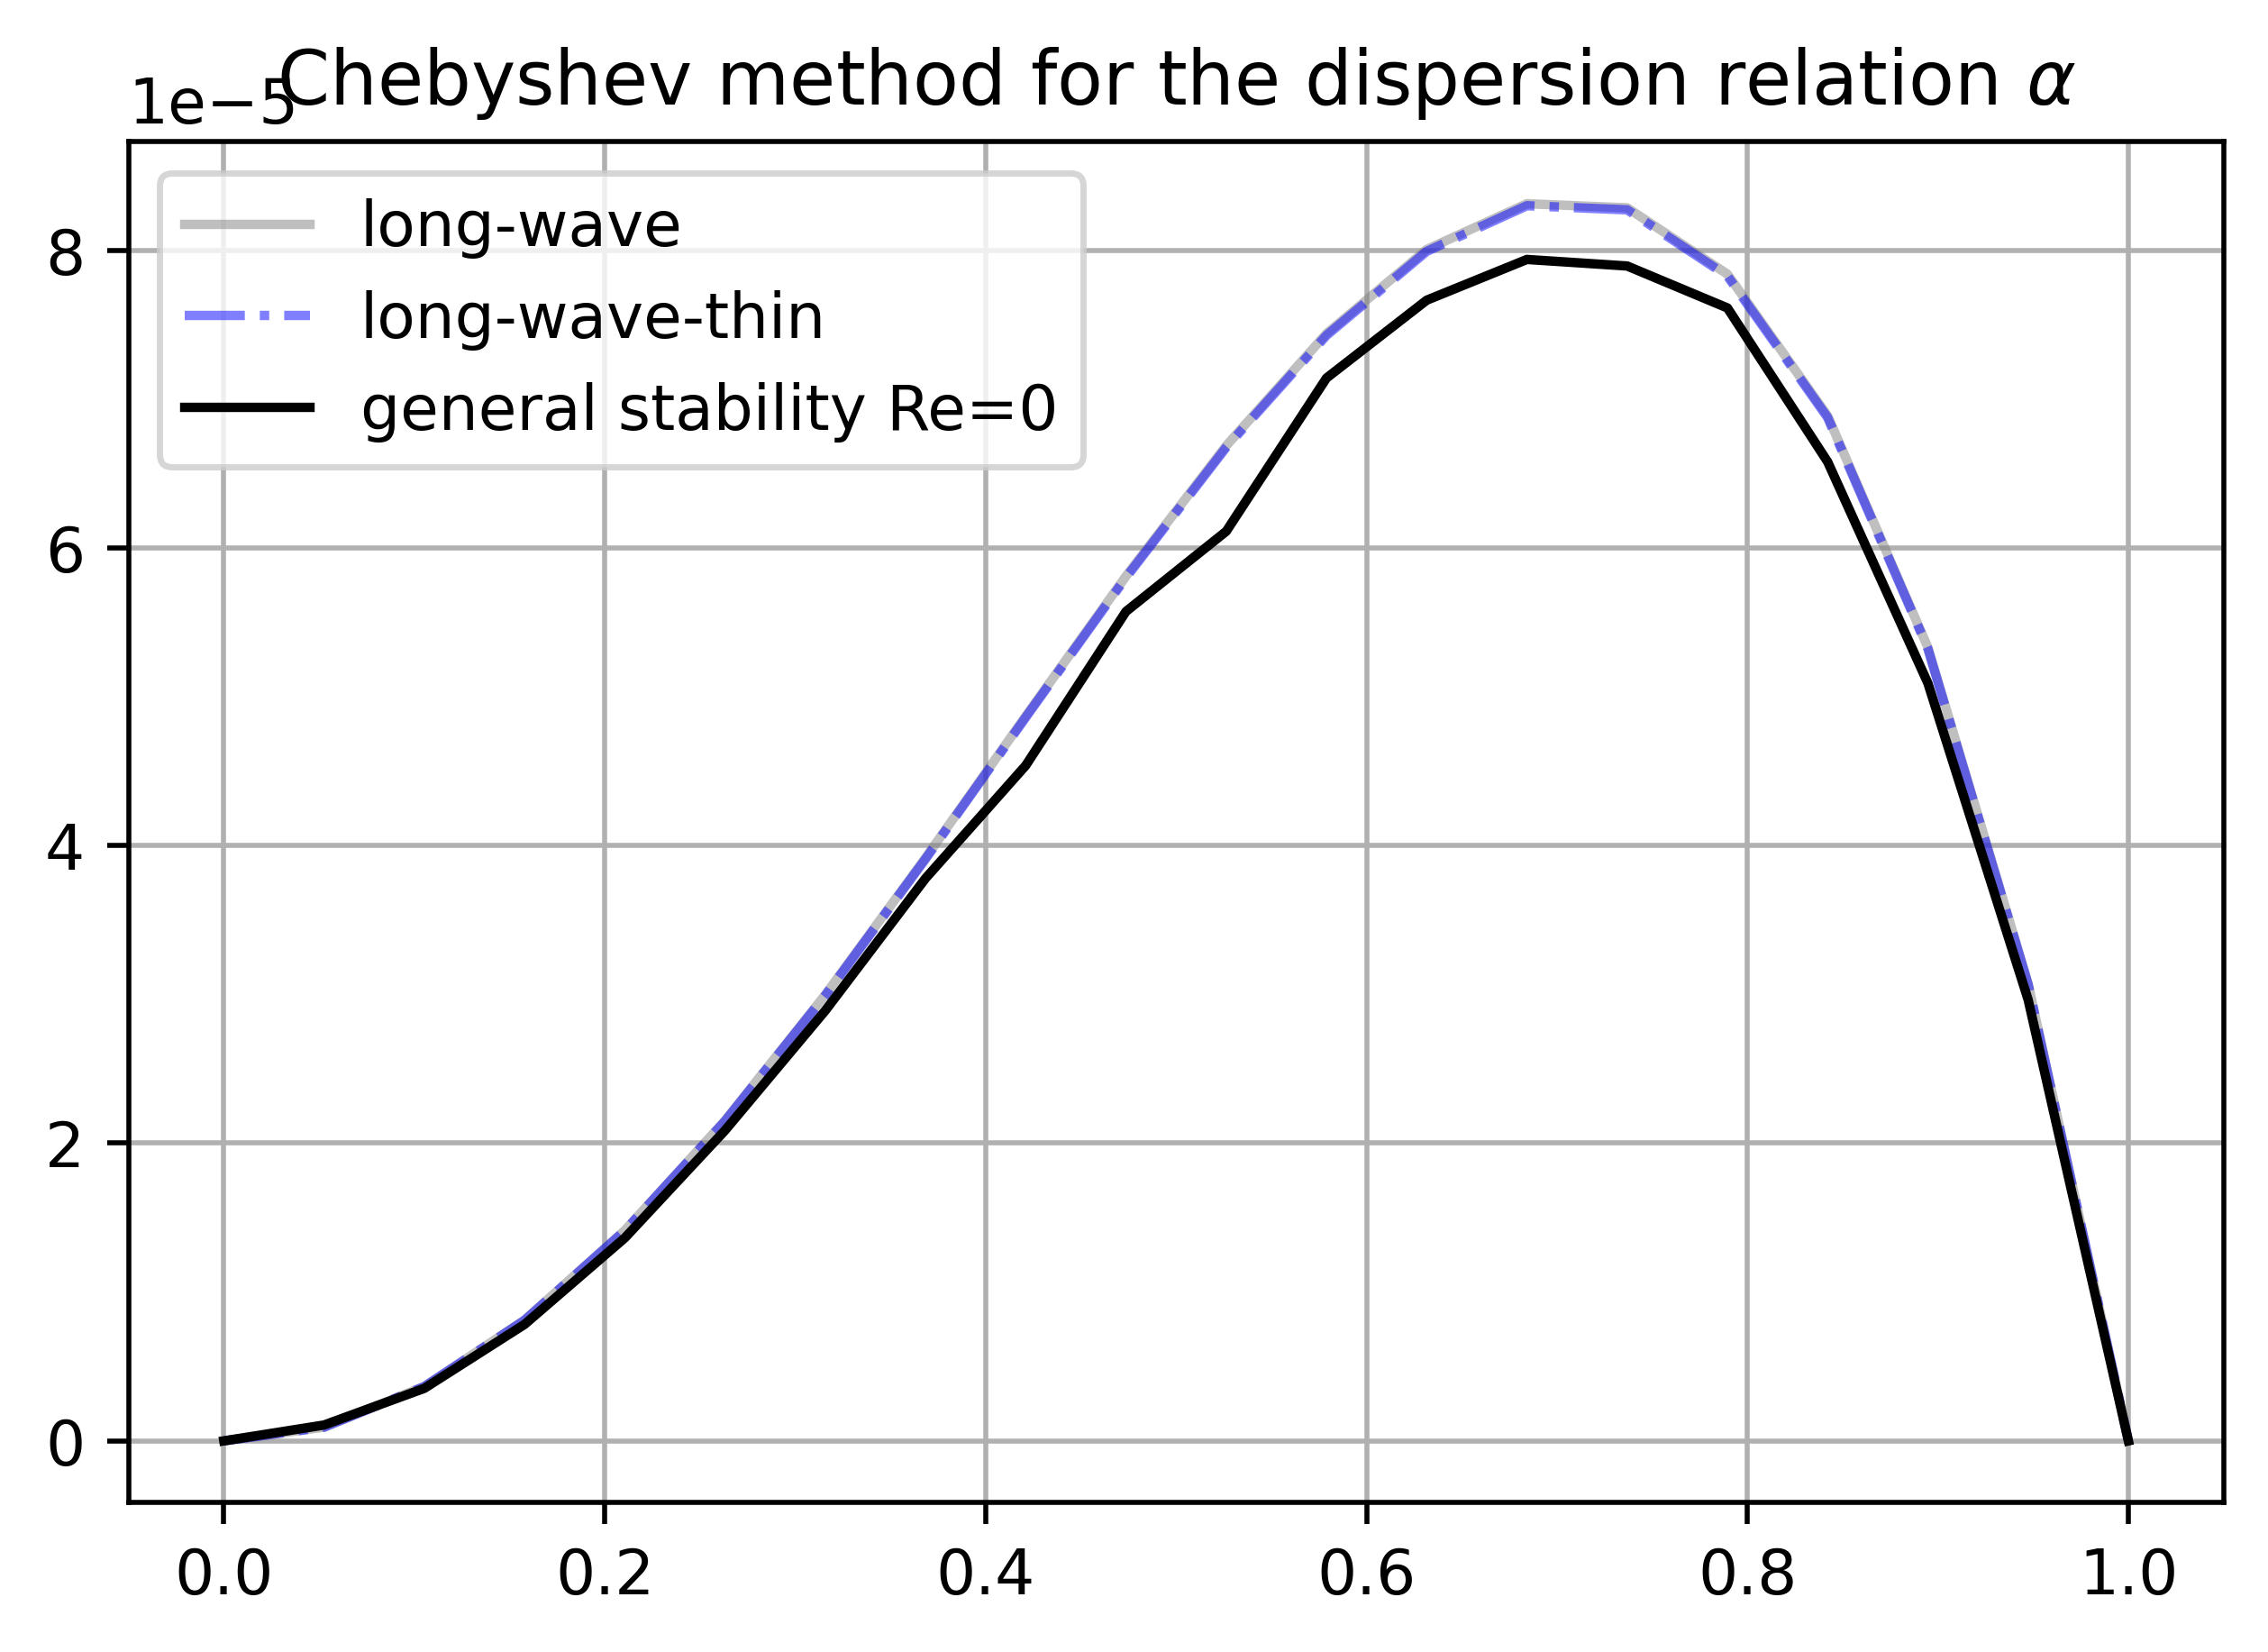

In [61]:
k_vect = kappa_vect/epsilon
D = 1-2*Ma
lambda_vect_thin = k_vect**2/3*(D - epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))
plt.figure(dpi=500)
plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='grey', alpha=0.5)
plt.plot(k_vect*epsilon, epsilon**2*lambda_vect_thin, '-.' , label='long-wave-thin', color='blue', alpha=0.5)
#plt.plot(kappa_vect, )
plt.plot(kappa_vect, epsilon*Lambda_vect.real, label ='general stability Re=0',color='black')
plt.legend()
plt.grid()
plt.title(r'Chebyshev method for the dispersion relation $\alpha$')
#plt.savefig(f'proof_of_working_method_chebyshev_alpha_{alpha}_with_Re_1.jpg')
plt.show()

# Continuation procedure
For each $k$, keep track of the growthrate $\Lambda(k)$. Then for $Re_j = Re_{j-1}+\Delta $, we select the eigenvalue $\Lambda_{j}(k)$ closest to $\Lambda_{j-1}(k)$

In [18]:
Re_list = np.linspace(0, 0.1, 3)
kappa_vect = np.linspace(0, 1, 20)
Lambda_array = np.zeros((len(kappa_vect), len(Re_list)))
r_interior = (1-alpha)*x_interior + (1+alpha) #(half)
for index_re, Re in enumerate(Re_list):
    Lambda_vect = Lambda_array[:, index_re]
    for index, kappa in enumerate(kappa_vect):
        #continuity first
        matrix_a_cont = np.zeros((N-1, N+1), dtype=complex)
        matrix_b_cont = np.zeros((N-1, N+1), dtype=complex)
        matrix_c_cont = np.zeros((N-1, N+1), dtype=complex)
        matrix_S_cont = np.zeros((N-1, 1), dtype = complex)

        matrix_a_cont += np.transpose(2/(1-alpha)*cheb_der[:,1:-1] + 2/(r_interior)*cheb_poly[:,1:-1])
        matrix_b_cont += np.transpose(1j*kappa*cheb_poly[:, 1:-1])

        matrix_cont = np.concatenate([matrix_a_cont, matrix_b_cont, matrix_c_cont, matrix_S_cont], axis=1)

        matrix_cont_forcing = np.zeros_like(matrix_cont)
        # Ns in r direction (or x direction now)
        matrix_a_NSr = np.zeros((N-1, N+1), dtype=complex)
        matrix_b_NSr = np.zeros((N-1, N+1), dtype=complex)
        matrix_c_NSr = np.zeros((N-1, N+1), dtype=complex)
        matrix_S_NSr = np.zeros((N-1, 1), dtype = complex)
        matrix_a_NSr_forcing = np.zeros((N-1, N+1), dtype=complex)

        matrix_a_NSr += np.transpose(Re*w_0(x_interior)*1j*kappa*cheb_poly[:, 1:-1] + kappa**2*cheb_poly[:, 1:-1])
        matrix_a_NSr += np.transpose(-4/(1-alpha)**2*cheb_der_der[:,1:-1] + 4/(r_interior**2)*cheb_poly[:,1:-1])
        matrix_a_NSr += np.transpose(-2*cheb_der[:,1:-1]/r_interior)

        matrix_c_NSr += np.transpose(2/(1-alpha)*cheb_der[:,1:-1])

        matrix_a_NSr_forcing += np.transpose(-Re*cheb_poly[:,1:-1])

        matrix_NSr = np.concatenate([matrix_a_NSr, matrix_b_NSr, matrix_c_NSr, matrix_S_NSr], axis=1)

        matrix_NSr_forcing = np.concatenate([matrix_a_NSr_forcing, np.zeros((N-1, N+1), dtype=complex), 
                                             np.zeros((N-1, N+1), dtype=complex), 
                                             np.zeros((N-1, 1), dtype = complex)], axis=1)

        #NS in z
        matrix_a_NSz = np.zeros((N-1, N+1), dtype=complex)
        matrix_b_NSz = np.zeros((N-1, N+1), dtype=complex)
        matrix_c_NSz = np.zeros((N-1, N+1), dtype=complex)
        matrix_S_NSz = np.zeros((N-1, 1), dtype = complex)
        matrix_b_NSz_forcing = np.zeros((N-1, N+1), dtype=complex)

        matrix_a_NSz += np.transpose(Re*w_0_prime(x_interior)*cheb_poly[:,1:-1])
        matrix_b_NSz += np.transpose(Re*1j*kappa*w_0(x_interior)*cheb_poly[:,1:-1]+kappa**2*cheb_poly[:,1:-1])
        matrix_b_NSz += np.transpose(-4/(1-alpha)**2*cheb_der_der[:,1:-1]-2/r_interior*cheb_der[:,1:-1])
        matrix_c_NSz += np.transpose(1j*kappa*cheb_poly[:,1:-1])

        matrix_b_NSz_forcing += np.transpose(-Re*cheb_poly[:,1:-1])
        matrix_NSz = np.concatenate([matrix_a_NSz, matrix_b_NSz, matrix_c_NSz, matrix_S_NSz], axis=1)

        matrix_NSz_forcing = np.concatenate([np.zeros((N-1, N+1), dtype=complex), matrix_b_NSz_forcing,
                                             np.zeros((N-1, N+1), dtype=complex), 
                                             np.zeros((N-1, 1), dtype = complex)], axis=1)
        # u(r = alpha) = u(x=-1)=0
        no_slip = np.transpose(cheb_poly[:,0]).reshape(1,-1)
        matrix_noslip_u = np.concatenate([no_slip,np.zeros_like(no_slip),np.zeros_like(no_slip)], axis=1)
        # no slip w
        matrix_noslip_w = np.concatenate([np.zeros_like(no_slip),no_slip,
                                          np.zeros_like(no_slip)], axis=1)
        # du/dr=0 at r=alpha (du/dx=0 at x=-1)
        derivative = np.transpose(cheb_der[:,0]).reshape(1, -1)
        matrix_no_derivative_u = np.concatenate([derivative, np.zeros_like(derivative),
                                          np.zeros_like(derivative)], axis=1)
        # join them and add column for S
        BC_at_wire_almost = np.concatenate([matrix_noslip_u, matrix_noslip_w, matrix_no_derivative_u], axis=0)
        matrix_BC_at_wire = np.concatenate([BC_at_wire_almost, np.zeros((3,1))], axis=1)
        matrix_BC_at_wire_forcing = np.zeros_like(matrix_BC_at_wire)


        #kinematic 
        length_row = len(np.transpose(cheb_poly[:,-1]).reshape(1,-1))
        condition_for_u = np.transpose(cheb_poly[:,-1]).reshape(1,-1)
        matrix_kinematic=np.concatenate([condition_for_u, 
                                       np.zeros_like(condition_for_u), 
                                       np.zeros_like(condition_for_u), 
                                       np.array([[-w_0(x[-1])*1j*kappa]])], axis=1)
        matrix_kinematic_forcing = np.concatenate([np.zeros_like(condition_for_u), np.zeros_like(condition_for_u),
                                                   np.zeros_like(condition_for_u), np.array([[1]])], axis = 1)

        # tangential 
        matrix_tangential = np.concatenate([1j*kappa*cheb_poly[:,-1].reshape(1,-1),
                                            2/(1-alpha)*cheb_der[:,-1].reshape(1,-1),
                                            np.zeros_like(condition_for_u),
                                           np.array([[-1]])], axis =1)

        #normal
        matrix_normal = np.concatenate([(-4*Ca/(1-alpha))*cheb_der[:,-1].reshape(1,-1), 
                                       np.zeros_like(condition_for_u), 
                                       Bo*cheb_poly[:,-1].reshape(1,-1), np.array([[(1-2*Ma)-kappa**2]])], axis=1)
        matrix_BC_free_surface = np.concatenate([matrix_kinematic, matrix_tangential, matrix_normal], axis=0)
        matrix_BC_free_surface_forcing = np.concatenate([matrix_kinematic_forcing,
                                                         np.zeros_like(matrix_kinematic_forcing),
                                                        np.zeros_like(matrix_kinematic_forcing)], 
                                                        axis=0)
        #continuity at r=1

        cont_at_free_surface = np.concatenate([(2/(1-alpha)*cheb_der[:,0] + 2/(x[-1])*cheb_poly[:,0]).reshape(1,-1), 
                                              (1j*kappa*cheb_poly[:, 0]).reshape(1,-1), 
                                              np.zeros_like((1j*kappa*cheb_poly[:, 0]).reshape(1,-1)), 
                                              np.array([[0]])], axis =1)



        matrix = np.concatenate([matrix_cont, matrix_NSr, matrix_NSz, 
                                 matrix_BC_at_wire, matrix_BC_free_surface, cont_at_free_surface],
                               axis=0)
        matrix_forcing = np.concatenate([matrix_cont_forcing, matrix_NSr_forcing, matrix_NSz_forcing, 
                                        matrix_BC_at_wire_forcing, matrix_BC_free_surface_forcing,
                                         np.zeros_like( cont_at_free_surface)], axis=0)
        #print(np.shape(matrix))
        #print(np.shape(matrix_forcing))
        evals = scipy.linalg.eigvals(matrix,matrix_forcing).real
        #print(evals)
        if Re == 0:
            Lambda_vect[index] = np.max(evals[~np.isinf(evals)])
        else: 
            prev_Lambda = Lambda_array[index,index_re-1]
            Lambda_vect[index] = evals[~np.isinf(evals)][np.argmin(np.abs(evals[~np.isinf(evals)]-prev_Lambda))]
        print((index+1)/len(kappa_vect)*100)
    Lambda_array[:, index_re] = Lambda_vect
    print()
    print(print((index_re+1)/len(Re_list)*100))
    print()

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.00000000000001
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0

33.33333333333333
None

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.00000000000001
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0

66.66666666666666
None

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.00000000000001
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0

100.0
None



In [16]:
evals[~np.isinf(evals)][np.argmin(np.abs(evals[~np.isinf(evals)]-0))]

0.0

array([ 1625.48477981,   -15.90553093,   -51.52005856,   -17.21566758,
        -164.58191965,  -126.44426866,  -238.75709703,  -677.35670829,
       -1014.68337124,   450.85899663,   445.7499717 ,  -310.56608272,
         -20.10716817,   245.77969588,   399.0357783 ,   622.77895702,
         473.17217676,   136.95781269,   406.88275292,   543.38971875])